# AutoML Run

Firstly, we import all the dependencies required for our AutoML Run.

In [1]:
from azureml.core import Workspace, Experiment
from azureml.core.compute import ComputeTarget,AmlCompute
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
import pandas as pd
import os
from azureml.core.webservice import AciWebservice, Webservice
import json
from azureml.core.model import Model
from azureml.core.compute_target import ComputeTargetException
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.core.model import InferenceConfig
import joblib
from azureml.core import Workspace, Environment
from azureml.core import Model
from sklearn.model_selection import train_test_split
from train import clean_data

# Dataset

This dataset is composed of a range of biomedical voice measurements from 31 people. Out of these,23 people had Parkinson's disease. Each column in the table corresponds to a particular voice measure. Each row corresponds to the voice recordings of 195 individuals.

The main aim of this dataset is to distinguish healthy people from those with the disease.The column "status" will be used for the same. The results will be binary where "1" represents healthy and "0" represents those with disease.

The Dataset is multivariate and in ASCII CSV format with following attributes:

## Attribute Information:

**Matrix column entries (attributes):**

- **name** - ASCII subject name and recording number <br>
- **MDVP:Fo(Hz)** - Average vocal fundamental frequency <br>
- **MDVP:Fhi(Hz)** - Maximum vocal fundamental frequency <br>
- **MDVP:Flo(Hz)** - Minimum vocal fundamental frequency <br>
- **MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP** - Several measures of variation in fundamental frequency <br>
- **MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA** - Several measures of variation in amplitude<br>
- **NHR,HNR** - Two measures of ratio of noise to tonal components in the voice <br>
- **status** - Health status of the subject (one) - Parkinson's, (zero) - healthy<br>
- **RPDE,D2** - Two nonlinear dynamical complexity measures<br>
- **DFA** - Signal fractal scaling exponent<br>
- **spread1,spread2,PPE** - Three nonlinear measures of fundamental frequency variation<br>

Below is the code for accessing the dataset.

In [2]:
ws = Workspace.from_config()
experiment_name = 'parkinsons-disease-automlrun'
 
exp = Experiment(workspace=ws, name=experiment_name) 

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Workspace name: quick-starts-ws-133204
Azure region: southcentralus
Subscription id: 2c48c51c-bd47-40d4-abbe-fb8eabd19c8c
Resource group: aml-quickstarts-133204


In [3]:
# Choose a name for your CPU cluster
cluster_name = "MyNewCluster"

# Verify that cluster does not exist already
try:
    compute = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_configuration = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS3_V2',
                                                           max_nodes=5)
    compute = ComputeTarget.create(ws, cluster_name, compute_configuration)


Found existing cluster, use it.


In [4]:
link='https://raw.githubusercontent.com/sg7801/Parkinsons-Disease-Prediction/main/parkinsons.txt'
ds = TabularDatasetFactory.from_delimited_files(path=link)
x, y = clean_data(ds)
df = pd.concat([x, y], axis = 1)
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


In [5]:
df_train, df_test = train_test_split(df, test_size=0.27)
df_train.to_csv("training/training_dataset.csv")
df_test.to_csv("validation/validation_dataset.csv")

In [6]:
datastore = ws.get_default_datastore()
datastore.upload(src_dir = "training/", target_path = "data/")
datastore.upload(src_dir = "validation/", target_path = "data/")

Uploading an estimated of 1 files
Target already exists. Skipping upload for data/training_dataset.csv
Uploaded 0 files
Uploading an estimated of 1 files
Target already exists. Skipping upload for data/validation_dataset.csv
Uploaded 0 files


$AZUREML_DATAREFERENCE_318184363d2942cd9cd9b8767dbd5507

In [7]:
training_data = TabularDatasetFactory.from_delimited_files(path = [(datastore, ("data/training_dataset.csv"))])
validation_data = TabularDatasetFactory.from_delimited_files(path = [(datastore, ("data/validation_dataset.csv"))])
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


# AutoML Configuration
Below are the reasons along description for AutoML settings and configuration used in the experiment:

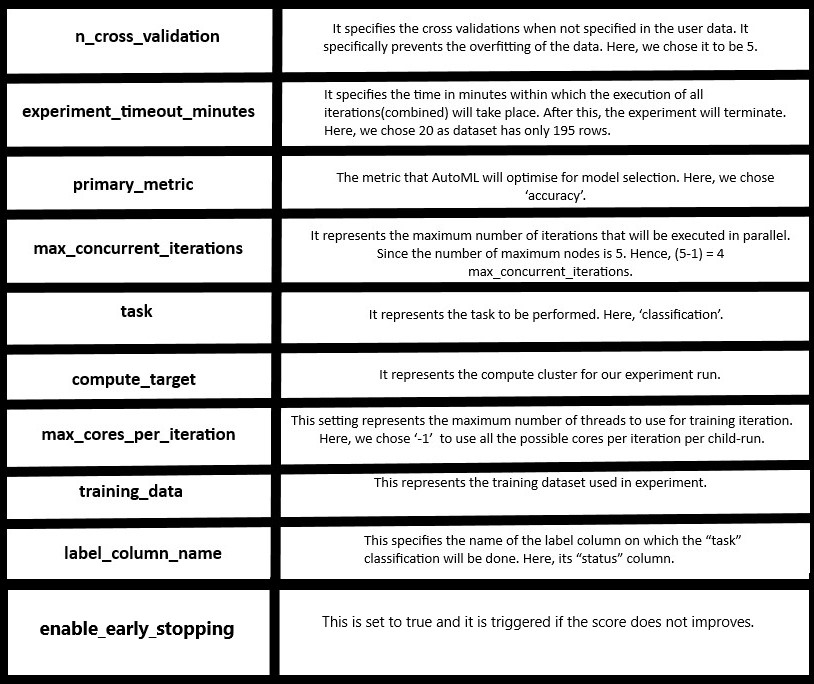


In [8]:
automl_settings = {
    "n_cross_validations": 5,
    "experiment_timeout_minutes" :20,
    "primary_metric": 'accuracy',
    "max_concurrent_iterations": 4,
}
automl_config = AutoMLConfig(
    task="classification",
    compute_target=compute,
    enable_early_stopping= True,
    max_cores_per_iteration=-1,
    training_data=training_data,
    label_column_name="status",
    **automl_settings
    )

In [9]:
auto_ml_run = exp.submit(config = automl_config, show_output = True)

Running on remote.
No run_configuration provided, running on MyNewCluster with default configuration
Running on remote compute: MyNewCluster
Parent Run ID: AutoML_e0d0cfdc-39bb-43fa-857f-9c27b4d624e7

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values 

## Run Details

Used the RunDetails widget to show the different experiments.

In [12]:
RunDetails(auto_ml_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Best Model

Retrieving and saving the best model

In [32]:
# Retrieve and save your best automl model.
best_run, fitted_model = auto_ml_run.get_output()
print(best_run)
print(fitted_model)
best_automl_model = best_run.register_model(model_name='parkinsons-best-model-in-automlrun', model_path='./')

Run(Experiment: parkinsons-disease-automlrun,
Id: AutoML_e0d0cfdc-39bb-43fa-857f-9c27b4d624e7_36,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                        class_weight=None,
                                                                                        coef0=0.0,
                                            

## Model Deployment

Firstly, we register the model, create an inference config and deploy the model as a web service.

In [34]:
os.makedirs('./amlmodel', exist_ok=True)
best_run.download_file('/outputs/model.pkl',os.path.join('./amlmodel','automl_best_model_park.pkl'))

In [35]:
for n in best_run.get_file_names():
    if n.startswith('outputs'):
        output_file_path = os.path.join('./amlmodel', n.split('/')[-1])
        print('Downloading to output file path..')
        best_run.download_file(name=n, output_file_path=output_file_path)

In [38]:
m=best_run.register_model(
            model_name = 'parkinsons-best-model-in-automl', 
            model_path = './outputs/model.pkl',
            model_framework=Model.Framework.SCIKITLEARN,
            description='Parkinson detection'
)

Now we will download the conda environment file and then define the environment

In [39]:
best_run.download_file('outputs/conda_env_v_1_0_0.yml', 'conda_env.yml')
env = Environment.from_conda_specification(name = 'env',
                                             file_path = 'conda_env.yml')

Now we download the scoring file produced by AutoML and set inference configuration

In [40]:
best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'score_auto_park.py')
inference_configuration = InferenceConfig(entry_script= 'score_auto_park.py',
                                    environment=env)

Setting the ACI Webservice Configuration

In [41]:
aci_configuration = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1, auth_enabled=True)

Now, we deploy model as Webservice

In [42]:
webservice = Model.deploy(workspace=ws, 
                       name='parkinsons-best-model-in-automl', 
                       models=[m], 
                       inference_config=inference_configuration,
                       deployment_config=aci_configuration,
                       overwrite=True)

In [43]:
webservice

AciWebservice(workspace=Workspace.create(name='quick-starts-ws-133204', subscription_id='2c48c51c-bd47-40d4-abbe-fb8eabd19c8c', resource_group='aml-quickstarts-133204'), name=parkinsons-best-model-in-automl, image_id=None, compute_type=None, state=ACI, scoring_uri=Transitioning, tags=None, properties={}, created_by={})

In [44]:
webservice.wait_for_deployment(show_output=True)
print('Service state:'+ webservice.state)
print('Scoring URI:' + webservice.scoring_uri)
print('Swagger URI:' + webservice.swagger_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.............................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Service state:Healthy
Scoring URI:http://743a1bb7-3e8f-4184-882f-3152eba6cf75.southcentralus.azurecontainer.io/score
Swagger URI:http://743a1bb7-3e8f-4184-882f-3152eba6cf75.southcentralus.azurecontainer.io/swagger.json


Now, we select any three samples from the dataframe.

In [46]:
x_df=df.sample(3)
y_df = x_df.pop('status')
x_df['Column1'] = 0.0

Now we convert the records to a json data file

In [47]:
record=x_df.to_dict(orient='records')
score_json = json.dumps({'data': record})
print(score_json)

{"data": [{"MDVP:Fo(Hz)": 110.739, "MDVP:Fhi(Hz)": 113.597, "MDVP:Flo(Hz)": 100.139, "MDVP:Jitter(%)": 0.00356, "MDVP:Jitter(Abs)": 3e-05, "MDVP:RAP": 0.0017, "MDVP:PPQ": 0.002, "Jitter:DDP": 0.0051, "MDVP:Shimmer": 0.01484, "MDVP:Shimmer(dB)": 0.133, "Shimmer:APQ3": 0.00754, "Shimmer:APQ5": 0.0095, "MDVP:APQ": 0.01285, "Shimmer:DDA": 0.02261, "NHR": 0.0043, "HNR": 26.55, "RPDE": 0.36909, "DFA": 0.776158, "spread1": -6.085567, "spread2": 0.192375, "D2": 1.889002, "PPE": 0.174152, "Column1": 0.0}, {"MDVP:Fo(Hz)": 203.184, "MDVP:Fhi(Hz)": 211.526, "MDVP:Flo(Hz)": 196.16, "MDVP:Jitter(%)": 0.00178, "MDVP:Jitter(Abs)": 9e-06, "MDVP:RAP": 0.00094, "MDVP:PPQ": 0.00106, "Jitter:DDP": 0.00283, "MDVP:Shimmer": 0.00958, "MDVP:Shimmer(dB)": 0.085, "Shimmer:APQ3": 0.00468, "Shimmer:APQ5": 0.0061, "MDVP:APQ": 0.00726, "Shimmer:DDA": 0.01403, "NHR": 0.00065, "HNR": 33.047, "RPDE": 0.340068, "DFA": 0.741899, "spread1": -7.964984, "spread2": 0.163519, "D2": 1.423287, "PPE": 0.044539, "Column1": 0.0}, 

In [48]:
op = webservice.run(score_json)

In [52]:
print(op)

{"result": [1, 0, 1]}


In [50]:
print(y_df)

172    0
34     0
3      1
Name: status, dtype: int64


In [51]:
print(webservice.get_logs())

2021-01-03T23:15:15,927467755+00:00 - iot-server/run 
2021-01-03T23:15:15,931785487+00:00 - rsyslog/run 
2021-01-03T23:15:15,934439592+00:00 - gunicorn/run 
rsyslogd: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libuuid.so.1: no version information available (required by rsyslogd)
2021-01-03T23:15:15,945186218+00:00 - nginx/run 
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml-envs/azureml_9c539d20199ae6be65c41c0382029684/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)
/usr/sbin/nginx: /azureml

Now, we delete the service as well as the compute target.

In [29]:
webservice.delete()